In [33]:
import random

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.sparse as sparse
from torch_geometric.nn import GCNConv

import torch
import geopandas as gpd
from shapely.geometry import LineString

import pickle


from two_channel_gnn import TwoChannelGNN
# from enhanced_two_channel_gnn import EnhancedTwoChannelGNN

# Abstract

1. Set up a toy example: 
    a. Define the graph 
    b. Visualize the graph with the base case (without policy interventions)
2. Define the model (move this later to an own class)
3. Create train und test data (toy example)
4. Test the model (toy example)

## 1. Set up a toy example

### 1a. Define the graph

In [34]:
# Load the dictionary
with open('../results/results_dict.pkl', 'rb') as f:
    results_dict = pickle.load(f)

In [35]:
def create_edge_index_and_tensors(gdf):
    # Ensure the GeoDataFrame is projected in a geographic CRS
    gdf = gdf.to_crs(epsg=4326)
    
    # Extract unique nodes (start and end points of LineStrings)
    nodes = {}
    edges = []
    activity_counts = []
    capacities = []
    freespeeds = []
    node_counter = 0

    for idx, row in gdf.iterrows():
        line = row['geometry']
        activity_count = row['activity_count']  # Extract activity count
        capacity = row['capacity']  # Extract capacity
        freespeed = row['freespeed']  # Extract freespeed speed
        if isinstance(line, LineString):
            start_point = line.coords[0]
            end_point = line.coords[-1]
            
            if start_point not in nodes:
                nodes[start_point] = node_counter
                node_counter += 1
            if end_point not in nodes:
                nodes[end_point] = node_counter
                node_counter += 1
            
            start_index = nodes[start_point]
            end_index = nodes[end_point]
            
            edges.append((start_index, end_index))
            activity_counts.append(activity_count)  # Store activity count for this edge
            capacities.append(capacity)  # Store capacity for this edge
            freespeeds.append(freespeed)  # Store freespeed speed for this edge
    
    # Create edge_index tensor
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    
    # Create activity_tensor
    activity_tensor = torch.tensor(activity_counts, dtype=torch.float)
    
    # Create policy_tensor
    policy_tensor = torch.tensor(list(zip(capacities, freespeeds)), dtype=torch.float)

    return edge_index, activity_tensor, policy_tensor, nodes

In [36]:
# Iterate through each element in results_dict

datasets = []
for key, df in results_dict.items():
    # Print the key
    print(f"Policy: {key}")
    
    # Check if the gdf is indeed a GeoDataFrame
    if isinstance(df, pd.DataFrame):
        gdf = gpd.GeoDataFrame(df, geometry='geometry')
        gdf.crs = "EPSG:2154"  # Assuming the original CRS is EPSG:2154
        gdf.to_crs("EPSG:4326", inplace=True)
        
        edge_index, activity_tensor, policy_tensor, nodes = create_edge_index_and_tensors(gdf)
        datasets.append((policy_tensor, activity_tensor))
        # print("Edge Index:\n", edge_index)
        # print("Activity Tensor:\n", activity_tensor)
        # print("Nodes:\n", nodes)
        
    else:
        print(f"The value for key '{key}' is not a GeoDataFrame.")

Policy: policy_1
Policy: policy_10
Policy: policy_10_11
Policy: policy_10_11_12
Policy: policy_11
Policy: policy_11_12
Policy: policy_11_12_13
Policy: policy_12
Policy: policy_12_13
Policy: policy_12_13_14
Policy: policy_13
Policy: policy_13_14
Policy: policy_13_14_15
Policy: policy_14
Policy: policy_14_15
Policy: policy_14_15_16
Policy: policy_15
Policy: policy_15_16
Policy: policy_15_16_17
Policy: policy_16
Policy: policy_16_17
Policy: policy_16_17_18
Policy: policy_17
Policy: policy_17_18
Policy: policy_17_18_19
Policy: policy_18
Policy: policy_18_19
Policy: policy_18_19_20
Policy: policy_19_20
Policy: policy_1_2
Policy: policy_1_2_3
Policy: policy_2
Policy: policy_20
Policy: policy_2_3
Policy: policy_2_3_4
Policy: policy_3
Policy: policy_3_4
Policy: policy_3_4_5
Policy: policy_4
Policy: policy_4_5
Policy: policy_4_5_6
Policy: policy_5
Policy: policy_5_6
Policy: policy_5_6_7
Policy: policy_6
Policy: policy_6_7
Policy: policy_6_7_8
Policy: policy_7
Policy: policy_7_8
Policy: policy_7

We need the following information:
a. For the the policy channel, we need: capacity, speed limit
b. For the flow channel, we need only activity_count. 

In [42]:
# Toy example
num_nodes = len(nodes)
num_edges = len(edge_index[0])
num_node_features = 1 # other features than geographic coordinates could include presence of amenities (traffic signals, ped. crossings) oder population density or land use in the vicinity of the intersection. 
num_edge_features = 3 # model: price for using the street, allowed speed, and bike paths yes/no
hidden_channels = 16 # Increasing the number of hidden channels can potentially allow the model to learn more complex features but also increases the computational cost and risk of overfitting. Experiment with different values


# # Create the multi-channel GNN model
# model = MultiChannelGNN(num_node_features, num_edge_features, hidden_channels)

# # Forward pass
# output = model(x, edge_index, policy_features, flow_features)
# print("Output shape:", output.shape)

## 2.c. Create train und test data

### 2. Split the data in train and test set

In [43]:
# Define the ratio for splitting (e.g., 80% training, 20% test)
train_ratio = 0.8
test_ratio = 1 - train_ratio

# Split the dataset into training and test sets
train_data_sets, test_data_sets = train_test_split(datasets, test_size=test_ratio, random_state=42)

# Print the sizes of the training and test sets
print(f"Number of training sets: {len(train_data_sets)}")
print(f"Number of test sets: {len(test_data_sets)}")

Number of training sets: 44
Number of test sets: 12


In [44]:
# Given edge index tensor

# Determine the number of edges
num_edges = edge_index.size(1)

# Initialize an empty adjacency matrix
adjacency_matrix = torch.zeros((num_edges, num_edges), dtype=torch.float32)

# Fill adjacency matrix based on edge index
for i in range(edge_index.size(1)):
    src, dst = edge_index[:, i]
    adjacency_matrix[src, dst] = 1
    adjacency_matrix[dst, src] = 1  # For undirected graph, set both directions

# Extract indices and values of non-zero entries
indices = torch.nonzero(adjacency_matrix, as_tuple=False).t()
values = adjacency_matrix[indices[0], indices[1]]

# Convert indices and values to a sparse tensor
adjacency_matrix_sparse = sparse.FloatTensor(indices, values, torch.Size([num_edges, num_edges]))
# The adjacency matrix should always correspond to what has features! I.e. for us, these are the edges, not the nodes. 

In [45]:
# visualize the data
def visualize_data(policy_features, flow_features, title):
    edges = edge_index.T.tolist()

    # Create a networkx graph from the edge list
    G = nx.Graph(edges)

    # Create a colormap for flow features
    flow_cmap = plt.cm.Reds     # colormap for flow features

    # Extract flow features from tensor
    flow_values = flow_features[:, 0].tolist()      # flow graph has only one feature atm

    # Normalize features for colormap mapping
    flow_min = 0
    flow_max = 100
    norm = Normalize(vmin=flow_min, vmax=flow_max)

    # Draw the graph with separate lines for flow features on each edge and annotations for policy features
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, seed=42)  # Layout for better visualization

    # Set to store processed edges
    processed_edges = set()

    # Draw edges for flow features and annotate with policy features
    for i, (u, v) in enumerate(edges):
        # Check if the edge has already been processed
        if (u, v) not in processed_edges and (v, u) not in processed_edges:
            flow_color = flow_cmap((flow_values[i] - flow_min) / (flow_max - flow_min))
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], edge_color=flow_color, width=2, alpha=0.7)

            # Annotate with policy feature values
            policy_values_str = ", ".join([f"{int(val)}" for val in policy_features[i]])
            plt.text((pos[u][0] + pos[v][0]) / 2, (pos[u][1] + pos[v][1]) / 2, f"({policy_values_str})", fontsize=8, color="black", ha="center", va="center")

            # Add the edge to the set of processed edges
            processed_edges.add((u, v))

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color="skyblue", alpha=0.8)

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_color="black")

    # Add colorbar for flow features
    flow_sm = plt.cm.ScalarMappable(norm=norm, cmap=flow_cmap)
    flow_sm.set_array([])
    plt.colorbar(flow_sm, label="Flow")
    plt.title(title)
    if "Train" in title:
        plt.savefig(f"visualisation/train_data/{title}.png", dpi = 500)
    else:
        plt.savefig(f"visualisation/test_data/{title}.png", dpi = 500)
    
# # Visualize training and test data
# for i, dataset in enumerate(train_data_sets):
#     visualize_data(dataset[0], dataset[1], f"Train Dataset {i+1}")

# for i, dataset in enumerate(test_data_sets):
#     visualize_data(dataset[0], dataset[1], f"Test Dataset {i+1}")

## 3. Train the model

In [46]:
# Example usage
policy_input_dim = 3  # Dimensionality of policy features
traffic_input_dim = 1  # Dimensionality of traffic flow features
hidden_dim = 32  # Dimensionality of hidden representations
num_nodes = 10  # Number of nodes in the graph

# Create an instance of the TwoChannelGNN
model = TwoChannelGNN(policy_input_dim, traffic_input_dim, hidden_dim)

num_epochs = 100

# Define loss function
criterion = nn.MSELoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for policy_features, flow_targets in train_data_sets:
        optimizer.zero_grad()
        
         # Assuming train_data_sets is a DataLoader or similar iterable
        policy_features = policy_features.float()  # Convert to float tensor if necessary
        flow_targets = flow_targets.float()  # Convert to float tensor if necessary
        
        # Forward pass
        predicted_flow = model(policy_features, flow_targets, adjacency_matrix)
        
        # Compute loss
        loss = criterion(predicted_flow, flow_targets)
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    # Calculate average loss for the epoch
    avg_loss = running_loss / len(train_data_sets)
    train_losses.append(avg_loss)  # Store the loss value
    # print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_data_sets)}")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (31216x2 and 3x32)

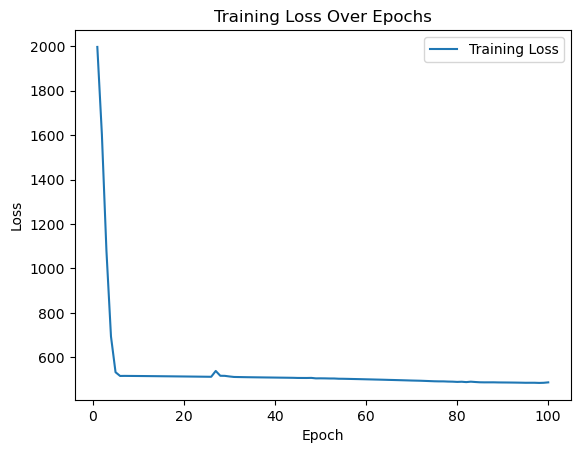

In [ ]:
# # Plot the training loss
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.savefig("visualisation/train_loss.png", dpi = 500)
plt.show()

## 4. Test the model

In [ ]:
# Initialize variables for evaluation
total_loss = 0.0
total_samples = 0

# Put model in evaluation mode
model.eval()

# Disable gradient calculation to save memory and computation
with torch.no_grad():
    for policy_features, flow_targets in test_data_sets:
        # Assuming test_data_sets is a DataLoader or similar iterable
        policy_features = policy_features.float()  # Convert to float tensor if necessary
        flow_targets = flow_targets.float()  # Convert to float tensor if necessary
        
        # Forward pass
        predicted_flow = model(policy_features, flow_targets, adjacency_matrix)
        
        # Compute loss
        loss = criterion(predicted_flow, flow_targets)
        print(loss.item())
        # Accumulate total loss and total samples
        total_loss += loss.item() * policy_features.size(0)
        total_samples += policy_features.size(0)

# Calculate average loss over all samples
average_loss = total_loss / total_samples
# squared differences between your model’s predictions and the actual target values.
# unit: squared flow values.

print(f"Average Test Loss: {average_loss}")

270.7248229980469
425.9009704589844
390.43560791015625
571.8687744140625
397.6443176269531
339.21173095703125
497.46942138671875
477.1165466308594
500.5747985839844
584.1795654296875
Average Test Loss: 445.5126556396484
